In [1]:
import sqlite3
import pandas as pd
import matplotlib as rc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
#------------------------------------------------------------------------------
# accept a dataframe, remove outliers, return cleaned data in a new dataframe
# see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
#------------------------------------------------------------------------------
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


In [3]:
# set style for seaborn
sns.set_style("whitegrid")
sns.set_context("paper")
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')


In [4]:
# connect to database
connection = sqlite3.connect("../output/db/bulk_analysis_2019-11-08_1000ms.db")


In [5]:
# load games and moves into dataframes 
df_game_dirty = pd.read_sql("SELECT * FROM game", connection)
df_move_dirty = pd.read_sql("SELECT * FROM move", connection)


# remove games that are either too short or too long
df_game = remove_outlier(df_game_dirty, "length")
df_move = df_move_dirty[df_move_dirty["game_id"].isin(df_game["id"])]



In [6]:
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})


Text(0.5, 0, 'ply')

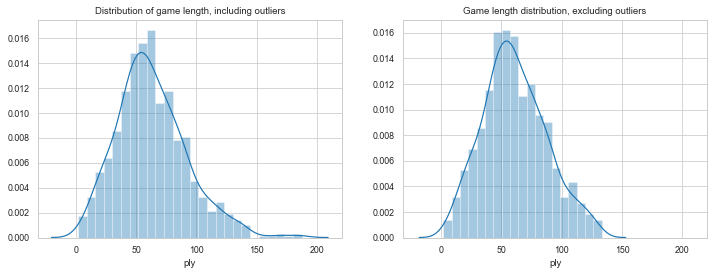

In [7]:
# unclean distribution

f, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
dist_dirty = sns.distplot(df_game_dirty["length"], ax=axes[0])
axes[0].set_title("Distribution of game length, including outliers")
axes[0].set_xlabel("ply")
dist_clean = sns.distplot(df_game["length"], ax=axes[1])
axes[1].set_title("Game length distribution, excluding outliers")
axes[1].set_xlabel("ply")


In [9]:
#f.savefig("dist_game_length.pgf")
f.savefig("dist_game_length.pdf")

Text(0, 0.5, 'ply')

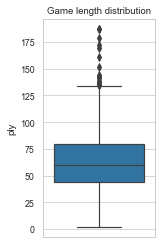

In [10]:
plt.figure(figsize=(2, 4))
box_game_length = sns.boxplot(y=df_game_dirty["length"])
box_game_length.set_title("Game length distribution")
box_game_length.set_ylabel("ply")

In [11]:
fig = box_game_length.get_figure()
#fig.savefig("boxplot_game_length.pgf")
fig.savefig("boxplot_game_length.pdf")


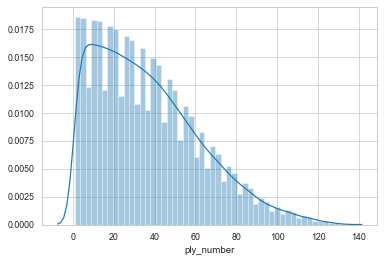

In [18]:
dist_plies = sns.distplot(df_move["ply_number"])
#df_plies = df_move.groupby("ply_number")["ply_number"].count()
df_plies = df_move.groupby("ply_number")["ply_number"]
print(df_plies)
#df_move.groupby("game_id").ply_number.max()
#sns.lineplot(x=df_move["ply_number"], y=df_move.groupby("ply_number").ply_number.count())


In [20]:
fig = dist_plies.get_figure()
fig.savefig("dist_plies.pdf")

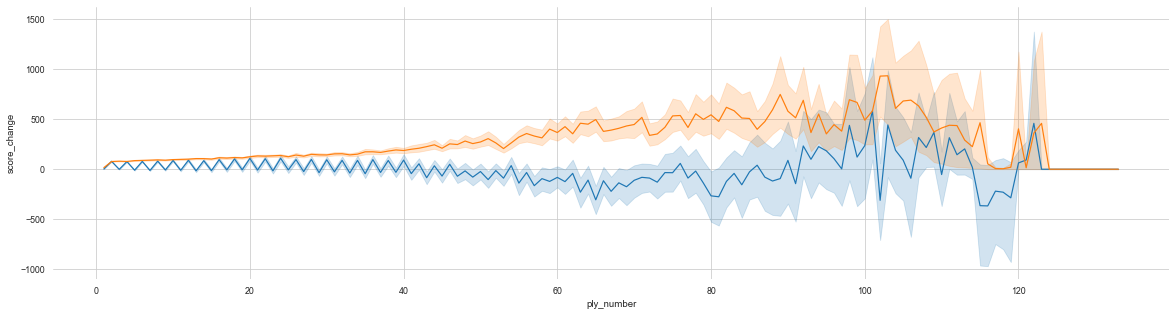

In [22]:
f, ax = plt.subplots(figsize=(20, 5))
line_score = sns.lineplot(x="ply_number", y="score", data=df_move)
sns.lineplot(x="ply_number", y="score_change", data=df_move)
sns.despine(left=True, bottom=True)

In [24]:
#fig = sns.get_figure()
f.savefig("scorevsscorechange.pdf")
# sns.lineplot(x=df_move["ply_number"], y=df_move.groupby("ply_number").ply_number.count())

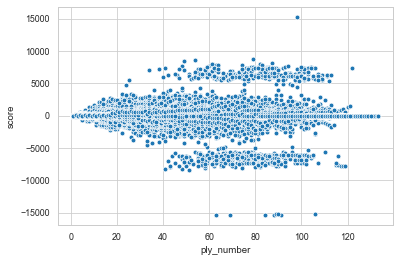

In [69]:
sns.scatterplot(x="ply_number", y="score", ci=68, data=df_move)
df_game_length = pd.read_sql("SELECT ply_number, COUNT(*) as game_length FROM move GROUP BY ply_number ORDER BY game_length DESC", connection)
line = sns.lineplot(x=df_game_length["ply_number"], y=df_game_length["game_length"], sort=True)